In [1]:
import numpy as np 
import pandas as pd 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(3607).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(3961).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(3958).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(3643).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(4088).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(3679).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(3506).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(4161).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(4121).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(3534).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(3596).jpg
/kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA/PNEUMONIA(3460).jpg
/kag

In [2]:
!pip install lime shap -q

In [3]:
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,  Flatten
from tensorflow.keras.optimizers import Adam
from PIL import Image
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import json
from tensorflow.keras.applications.vgg16 import preprocess_input
from lime import lime_image
import shap
from skimage.segmentation import mark_boundaries
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.io import imread
from skimage.transform import resize
from skimage.segmentation import mark_boundaries
from sklearn.metrics import roc_auc_score
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Input

2025-05-03 15:20:24.665449: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746285625.037871      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746285625.155539      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
base_path = "/kaggle/input/feature-selelcted-dataset"
categories = ['normal', 'covid19', 'pneumonia']
image_size = (224, 224)

In [5]:
def load_images_from_folder(folder, label_name, images_list, labels_list):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        img = cv2.imread(file_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            images_list.append(img)
            labels_list.append(label_name)

In [6]:
train_path = os.path.join(base_path, 'train')
train_images, train_labels = [], []

for category in categories:
    category_path = os.path.join(train_path, category)
    print(f"Loading training data from {category_path}...")
    load_images_from_folder(category_path, category, train_images, train_labels)

Loading training data from /kaggle/input/feature-selelcted-dataset/train/normal...
Loading training data from /kaggle/input/feature-selelcted-dataset/train/covid19...
Loading training data from /kaggle/input/feature-selelcted-dataset/train/pneumonia...


In [7]:
test_path = os.path.join(base_path, 'test')
test_images, test_labels = [], []

for category in categories:
    category_path = os.path.join(test_path, category)
    print(f"Loading test data from {category_path}...")
    load_images_from_folder(category_path, category, test_images, test_labels)

Loading test data from /kaggle/input/feature-selelcted-dataset/test/normal...
Loading test data from /kaggle/input/feature-selelcted-dataset/test/covid19...
Loading test data from /kaggle/input/feature-selelcted-dataset/test/pneumonia...


In [8]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)


In [9]:
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [10]:
label_mapping = {'covid19': 0, 'pneumonia': 1,'normal': 2}

train_labels_int = np.array([label_mapping[label] for label in train_labels], dtype='int32')
test_labels_int = np.array([label_mapping[label] for label in test_labels], dtype='int32')

train_labels = tf.keras.utils.to_categorical(train_labels_int, num_classes=3).astype('float32')
test_labels= tf.keras.utils.to_categorical(test_labels_int, num_classes=3).astype('float32')

In [11]:
class_dict_c = {0:'COVID19',
              1:'NORMAL',
              2:'PNEUMONIA'}

#  Model to Classify Normal, Covid19, Pneumonia

In [12]:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output

x = Flatten()(x)

x = Dense(4096, activation='relu')(x)  
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)  
x = Dropout(0.5)(x)
x = Dense(3, activation='softmax')(x)  #changed this not like the paper bec i have only 3 classes

# Create the final model
model_c = Model(inputs=base_model.input, outputs=x)

# Compile the model
model_c.compile(optimizer=Adam(learning_rate=0.001), #learning rate 0.001 like the paper
               loss='categorical_crossentropy', #sparse_categorical_crossentropy like the paper
              metrics=['accuracy'])

# Print model summary
model_c.summary()

I0000 00:00:1746285673.288133      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746285673.288874      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,272,835 (512.21 MB)

 Trainable params: 119,558,147 (456.08 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
batch_size = 32 #batch_size 32 like the paper
epochs = 10

# Train the model
history_c = model_c.fit(
    train_images, train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_images, test_labels),
    verbose=1
)


Epoch 1/10


I0000 00:00:1746285680.708075      71 service.cc:148] XLA service 0x7a9a500117e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746285680.709715      71 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746285680.709745      71 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746285681.163172      71 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/38 ━━━━━━━━━━━━━━━━━━━━ 10:01 16s/step - accuracy: 0.1875 - loss: 1.5076

I0000 00:00:1746285693.830755      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


38/38 ━━━━━━━━━━━━━━━━━━━━ 40s 639ms/step - accuracy: 0.4702 - loss: 11.7230 - val_accuracy: 0.7748 - val_loss: 0.4979
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 212ms/step - accuracy: 0.7306 - loss: 0.5469 - val_accuracy: 0.8245 - val_loss: 0.4173
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - accuracy: 0.8220 - loss: 0.4009 - val_accuracy: 0.8179 - val_loss: 0.4010
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 218ms/step - accuracy: 0.8164 - loss: 0.3870 - val_accuracy: 0.7748 - val_loss: 0.4628
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 221ms/step - accuracy: 0.8216 - loss: 0.4247 - val_accuracy: 0.8609 - val_loss: 0.3532
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 223ms/step - accuracy: 0.8346 - loss: 0.3740 - val_accuracy: 0.8543 - val_loss: 0.3478
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 225ms/step - accuracy: 0.8459 - loss: 0.3589 - val_accuracy: 0.8278 - val_loss: 0.3590
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 228ms/step - accuracy: 0.8569 - loss: 0.2910 - val_accuracy: 0.8808 - va

# Training and Validation Loss

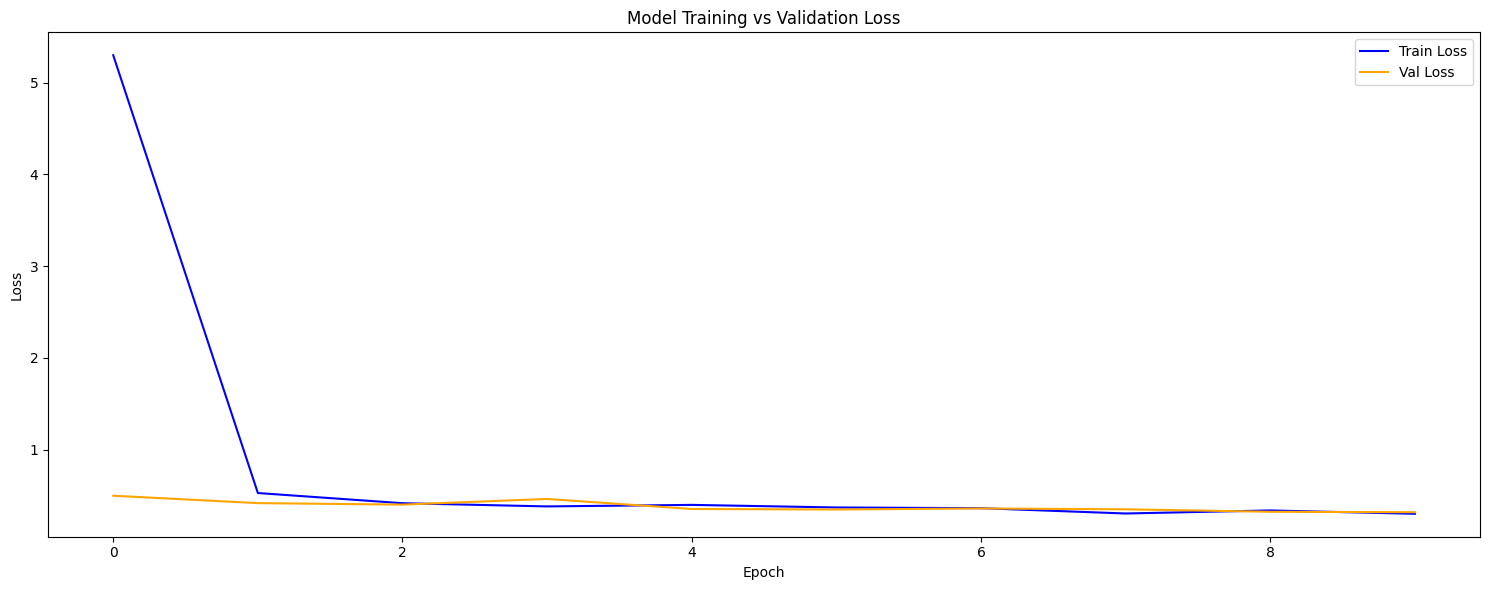

In [14]:
plt.figure(figsize=(15, 6))

plt.plot(history_c.history['loss'], label='Train Loss', color='blue')
plt.plot(history_c.history['val_loss'], label='Val Loss', color='orange')
plt.title('Model Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


# Training and Validation Accuracy

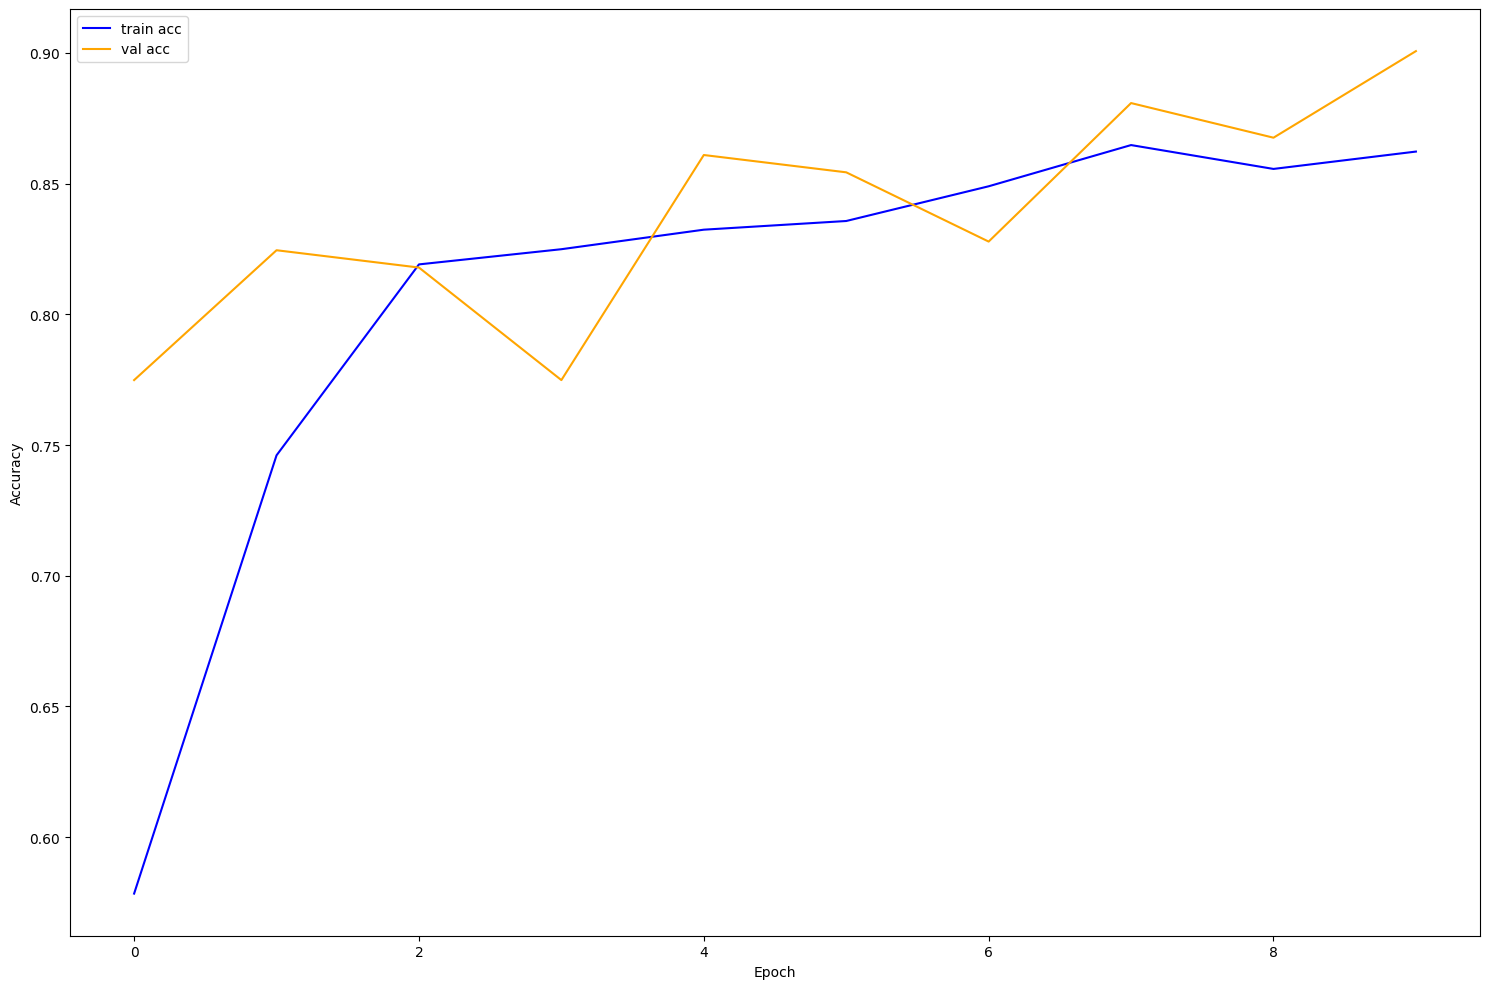

In [15]:
plt.figure(figsize=(15, 10))

plt.plot(history_c.history['accuracy'], label='train acc', color='blue')
plt.plot(history_c.history['val_accuracy'], label='val acc', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


#  Confusion Matrix

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step


Text(0.5, 1.0, 'Confusion Matrix')

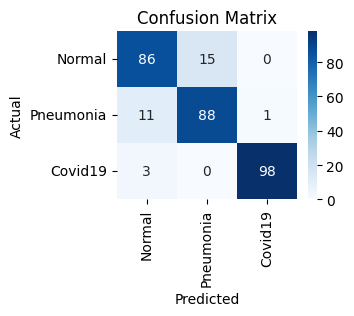

In [16]:
y_pred = model_c.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

class_names = ['Normal', 'Pneumonia', 'Covid19']
true_classes = np.argmax(test_labels, axis=1)

cm = confusion_matrix(true_classes, y_pred_classes)

plt.subplot(2, 2, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

In [17]:
auc = roc_auc_score(test_labels, y_pred, multi_class='ovr')  
print("AUC Score is: ", auc)

AUC Score is:  0.9683634632119928


# GRAD CAM

In [18]:
def gradCam(image, true_label, layer_conv_name, model, which):
    model_grad = tf.keras.models.Model(inputs=model.input, 
                                       outputs=[model.get_layer(layer_conv_name).output, 
                                                model.output])
    pred = []
    loss = None
    with tf.GradientTape() as tape:
        conv_output, predictions = model_grad(image)

        pred.append(np.argmax(predictions))
        
        tape.watch(conv_output)
        if which == "Categorical":
          loss = tf.keras.losses.categorical_crossentropy(true_label, predictions)
        else:
          loss = tf.losses.binary_crossentropy(true_label, predictions)
        
    
    grad = tape.gradient(loss, conv_output)
    grad = tf.reduce_mean(tf.abs(grad), axis=(0, 1, 2))
    
    conv_output = np.squeeze(conv_output.numpy())
    
    for i in range(conv_output.shape[-1]):
        conv_output[:, :, i] *= grad[i]
        
    heatmap = tf.reduce_mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / tf.reduce_max(heatmap + 1e-8)  
    heatmap = cv2.resize(heatmap.numpy(), (224, 224))
    pred = np.array(pred)
    return np.squeeze(heatmap), np.squeeze(image), pred

In [19]:
def getHeatMap(images, labels, model, which):
    heatmaps = []
    predictions = []
    for index in range(128):
        heatmap, image, pred = gradCam(images[index:index+1], 
                                 labels[index:index+1], 
                                 'block5_conv3', model, which) 
        heatmaps.append(heatmap)
        predictions.append(pred)
    return np.array(heatmaps), predictions

In [20]:
class_dict_c = {0:'covid19',
              1:'normal',
              2:'pneumonia'}
def draw(images, gradcam_heatmaps, labels, pred,  num_images=6):
    plt.figure(figsize=(12, 4 * num_images))
    for i in range(num_images):
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(images[i])
        title_pred = class_dict_c[pred[i][0]]
        title_actual = class_dict_c[np.argmax(labels[i])]
        plt.title(f'Predicted: {title_pred}\nActual: {title_actual}')

  
        
        plt.axis('off')

        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(images[i])
        plt.imshow(gradcam_heatmaps[i], alpha=0.6, cmap='jet')
        plt.title('Grad-CAM')
        plt.axis('off')

    plt.tight_layout()
    plt.show()



# GRADCAM with model for classifying Normal or Covid19 or Pneumonia

In [21]:
heatmaps, pred = getHeatMap(test_images, test_labels, model_c, "Categorical")
print(heatmaps.shape)

(128, 224, 224)


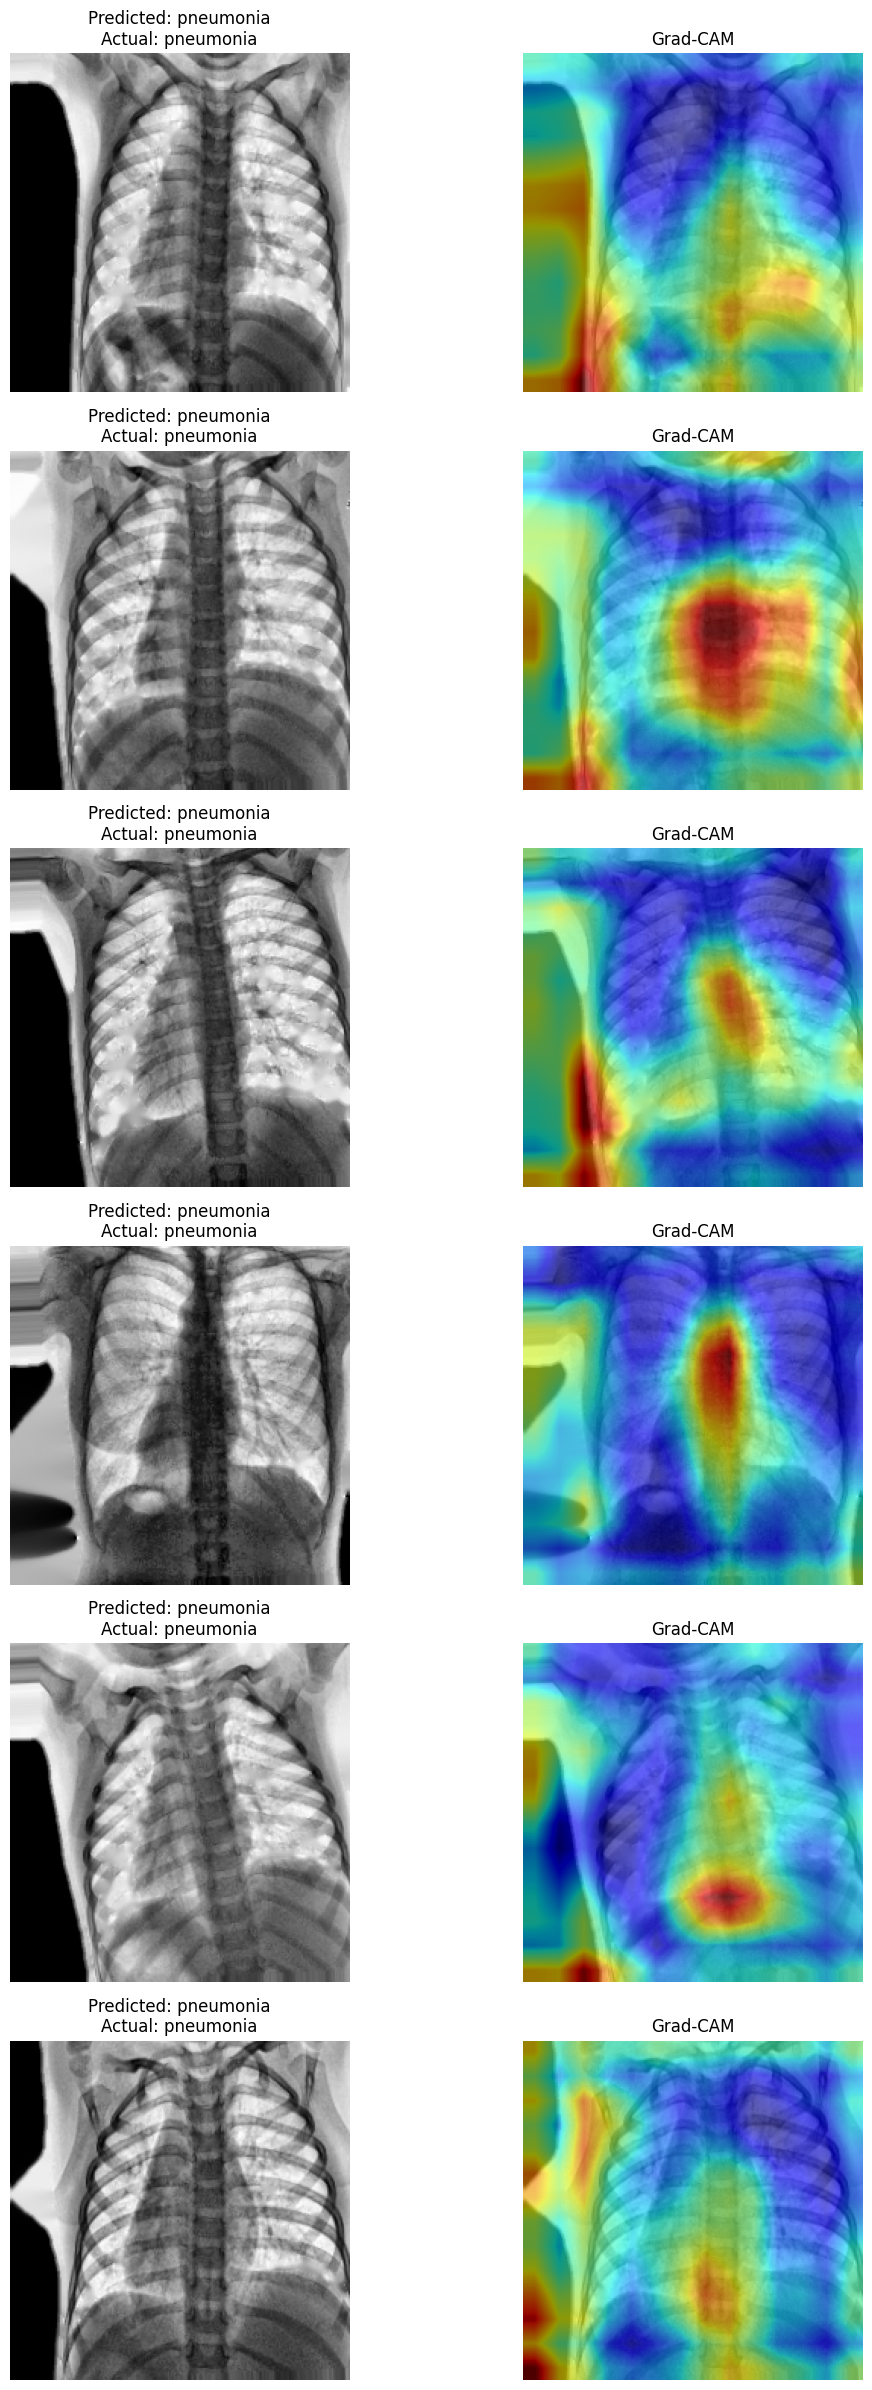

In [22]:
draw(test_images[:6], heatmaps[:6], test_labels[:6], pred)

# Explainability with Lime

# LIME with model for classifying Normal or Covid19 or Pneumonia

In [23]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.io import imread
from skimage.transform import resize
from skimage.segmentation import mark_boundaries

In [24]:
def preprocess_image(image_path):
    try:
        img = imread(image_path, as_gray=False)
        img = resize(img, (224, 224), anti_aliasing=True)
        if len(img.shape) == 2:
            img_rgb = np.stack([img] * 3, axis=-1)
        elif img.shape[-1] == 1:
            img_rgb = np.repeat(img, 3, axis=-1)
        else:
            img_rgb = img
        img_normalized = img_rgb / 255.0 if img_rgb.max() > 1 else img_rgb
        if len(img.shape) == 2 or (len(img.shape) == 3 and np.all(img[:, :, 0] == img[:, :, 1]) and np.all(img[:, :, 1] == img[:, :, 2])):
            img_viz = img if len(img.shape) == 2 else img[:, :, 0]
        else:
            img_viz = img_rgb
        return img_normalized, img_viz
    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None, None

In [25]:
def predict_fn(images):
    images = np.array(images)
    if images.shape[-1] != 3:
        images = np.repeat(images, 3, axis=-1)
    images = np.clip(images, 0, 1)
    return model_c.predict(images, verbose=0)

In [26]:
def explain_with_lime(model, image_paths_with_labels):
    explainer = lime_image.LimeImageExplainer()
    segmenter = SegmentationAlgorithm('quickshift', kernel_size=2, max_dist=100, ratio=0.2)

    for image_path, class_name in image_paths_with_labels:
        img_normalized, img_viz = preprocess_image(image_path)
        if img_normalized is None:
            print(f"Skipping {image_path} due to preprocessing error.")
            continue

        try:
            explanation = explainer.explain_instance(
                img_normalized,
                predict_fn,
                top_labels=3,
                hide_color=None,
                num_samples=500,
                segmentation_fn=segmenter
            )
        except Exception as e:
            print(f"Error explaining image {image_path}: {e}")
            continue

        pred = model.predict(np.expand_dims(img_normalized, axis=0), verbose=0)
        predicted_class = class_labels[np.argmax(pred)]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

        ax1.imshow(img_viz, cmap='gray' if len(img_viz.shape) == 2 else None)
        ax1.set_title(f'Original ({class_name})\nPredicted: {predicted_class}')
        ax1.axis('off')

        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[0],
            positive_only=True,
            num_features=5,
            hide_rest=False
        )

        base_image = img_viz
        if len(base_image.shape) == 2:
            overlay = np.zeros_like(base_image)
            overlay[mask == 1] = 1
            alpha = 0.3
            highlighted_image = (1 - alpha) * base_image + alpha * overlay
            highlighted_image = np.clip(highlighted_image, 0, 1)
            cmap = 'gray'
        else:
            overlay = np.zeros_like(base_image)
            overlay[mask == 1] = [1, 0, 0]
            alpha = 0.3
            highlighted_image = (1 - alpha) * base_image + alpha * overlay
            highlighted_image = np.clip(highlighted_image, 0, 1)
            cmap = None

        highlighted_image = mark_boundaries(highlighted_image, mask, color=(1, 0, 0), mode='thick')
        ax2.imshow(highlighted_image, cmap=cmap)
        ax2.set_title('LIME Highlights')
        ax2.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"Image: {image_path}")
        print(f"Predicted probabilities: {dict(zip(class_labels, pred[0]))}\n")

  0%|          | 0/500 [00:00<?, ?it/s]

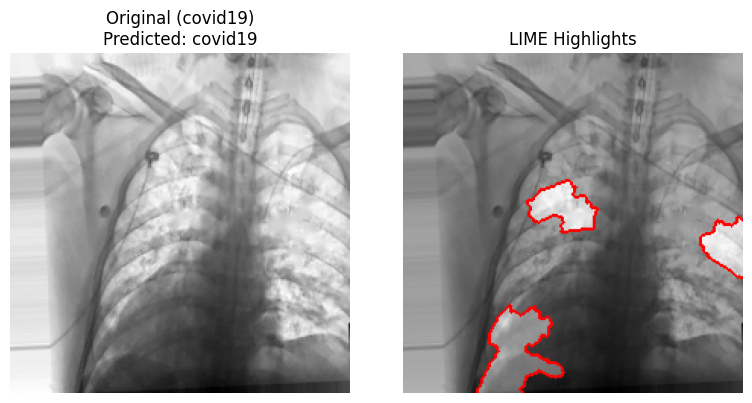

Image: /kaggle/input/feature-selelcted-dataset/test/covid19/image_253.png
Predicted probabilities: {'covid19': 0.8634455, 'normal': 0.11760584, 'pneumonia': 0.018948663}



  0%|          | 0/500 [00:00<?, ?it/s]

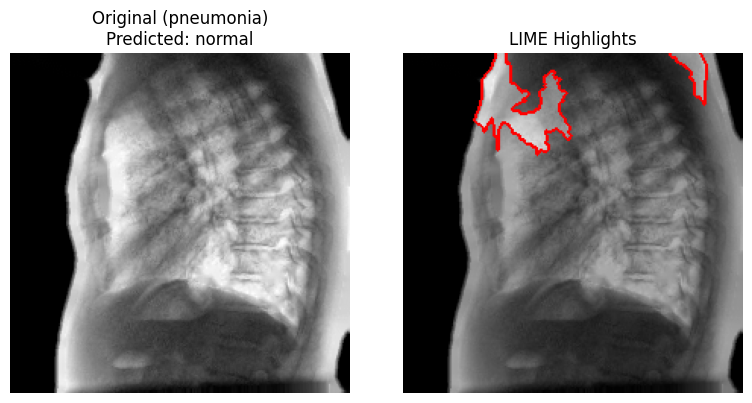

Image: /kaggle/input/feature-selelcted-dataset/test/pneumonia/image_281.png
Predicted probabilities: {'covid19': 0.041677628, 'normal': 0.9552816, 'pneumonia': 0.003040829}



  0%|          | 0/500 [00:00<?, ?it/s]

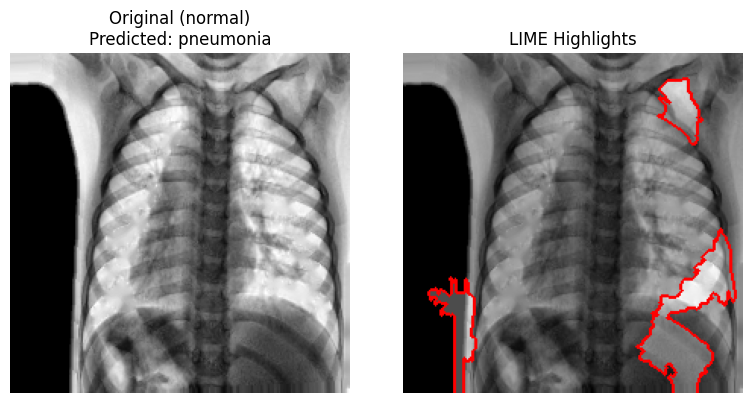

Image: /kaggle/input/feature-selelcted-dataset/test/normal/image_301.png
Predicted probabilities: {'covid19': 5.5009925e-13, 'normal': 4.3589674e-14, 'pneumonia': 1.0}



In [27]:
class_labels = ['covid19', 'normal', 'pneumonia']
test_dir = '/kaggle/input/feature-selelcted-dataset/test'
try:
    image_paths = [
        (os.path.join(test_dir, 'covid19', os.listdir(os.path.join(test_dir, 'covid19'))[0]), 'covid19'),
        (os.path.join(test_dir, 'pneumonia', os.listdir(os.path.join(test_dir, 'pneumonia'))[0]), 'pneumonia'),
        (os.path.join(test_dir, 'normal', os.listdir(os.path.join(test_dir, 'normal'))[0]), 'normal')
    ]
    explain_with_lime(model_c, image_paths)
except Exception as e:
    print(f"Error loading sample images: {e}")

# DeepLift

# LIME with model for classifying Normal or Patient

In [28]:
def deeplift(model, img, baseline=None, pred_index=None):
    if baseline is None:
        baseline = np.zeros_like(img)
    img = tf.convert_to_tensor(img, dtype=tf.float32)
    baseline = tf.convert_to_tensor(baseline, dtype=tf.float32)
    
    # difference between input and baseline
    diff = img - baseline
    
    # gradients of the predicted class VS respect to the input
    with tf.GradientTape() as tape:
        tape.watch(img)
        preds = model(img)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        score = preds[:, pred_index]
    
    grads = tape.gradient(score, img)
    
    # DeepLIFT multipliers: approximate as gradients
    multipliers = grads
    
    # contribution scores: (input - baseline) * multipliers
    contributions = diff * multipliers
    
    # Sum across channels + absolute
    heatmap = tf.reduce_sum(tf.abs(contributions), axis=-1).numpy()
    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-10)  # Normalize
    return heatmap, pred_index

In [29]:
def display_heatmap(img, heatmap, alpha=0.5):
    if img.ndim == 4:
        img = img[0]
    if heatmap.ndim == 3:
        heatmap = heatmap[0]
    
    img = np.uint8(255 * (img - img.min()) / (img.max() - img.min() + 1e-10))
    
    heatmap = np.uint8(255 * heatmap)
    heatmap = tf.image.resize(heatmap[..., np.newaxis], (img.shape[0], img.shape[1])).numpy()[..., 0]
    heatmap = np.uint8(plt.cm.jet(heatmap)[..., :3] * 255)
    
    superimposed_img = heatmap * alpha + img * (1 - alpha)
    return np.uint8(superimposed_img)

In [30]:
# Select 3 samples per class
num_classes = 3
samples_per_class = 3
class_indices = np.argmax(test_labels, axis=1)

selected_images = []
selected_labels = []

for class_idx in range(num_classes):
    # Find indices of samples belonging to this class
    class_samples = np.where(class_indices == class_idx)[0]
    if len(class_samples) < samples_per_class:
        print(f"Warning: Class {class_idx} has only {len(class_samples)} samples, using all available.")
        selected_samples = class_samples
    else:
        selected_samples = np.random.choice(class_samples, size=samples_per_class, replace=False)
    
    selected_images.extend(test_images[selected_samples])
    selected_labels.extend(test_labels[selected_samples])

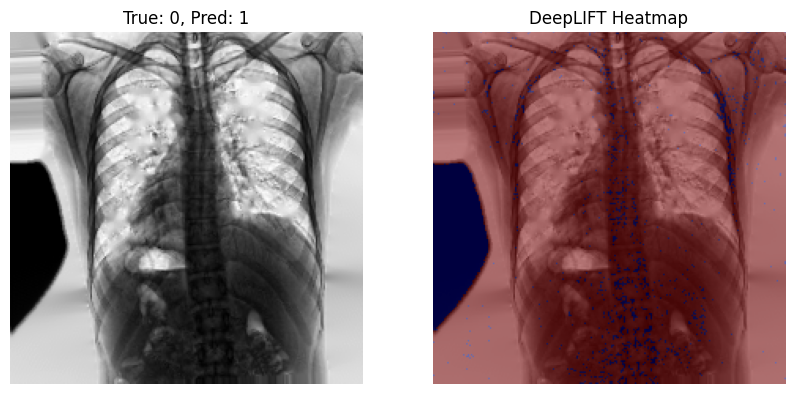

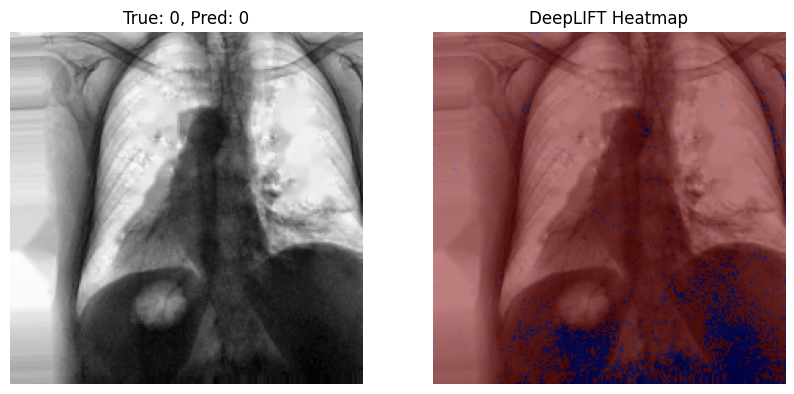

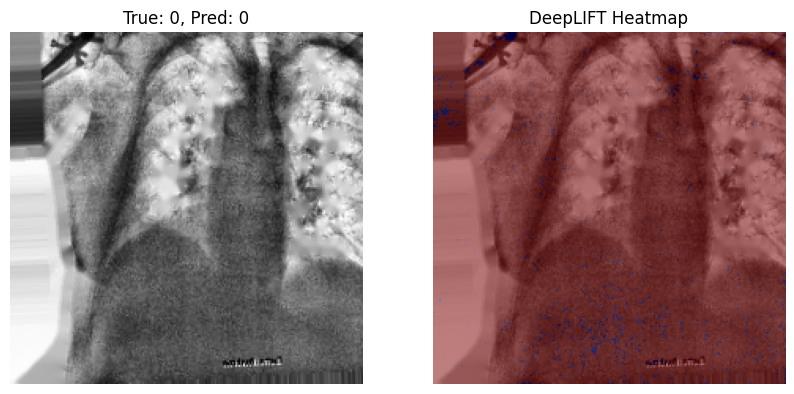

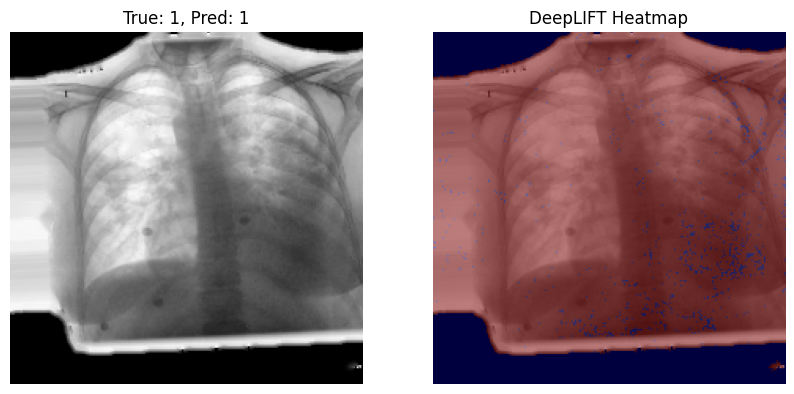

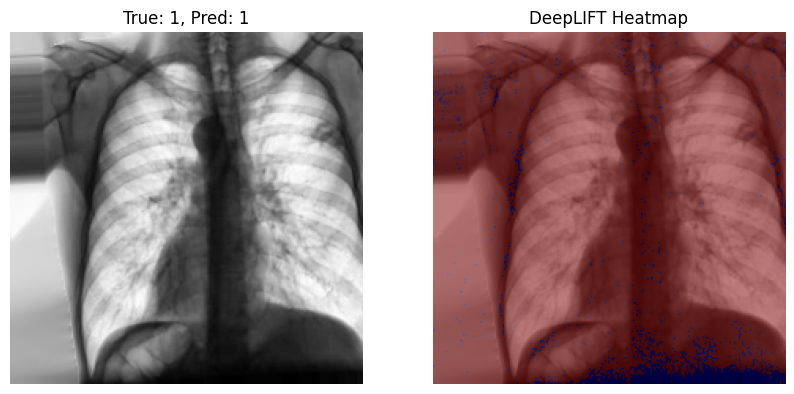

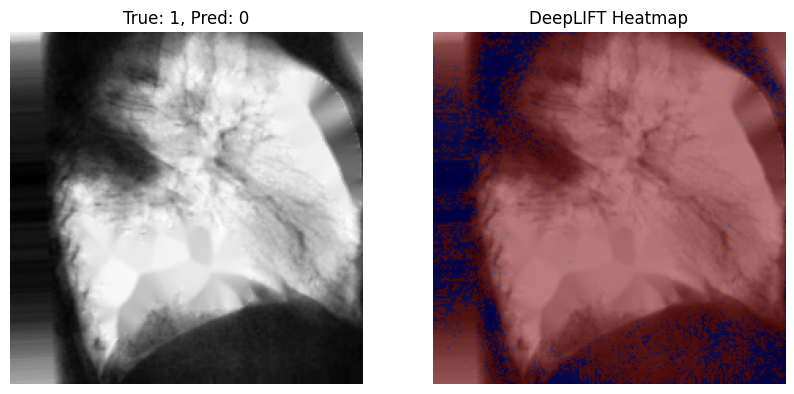

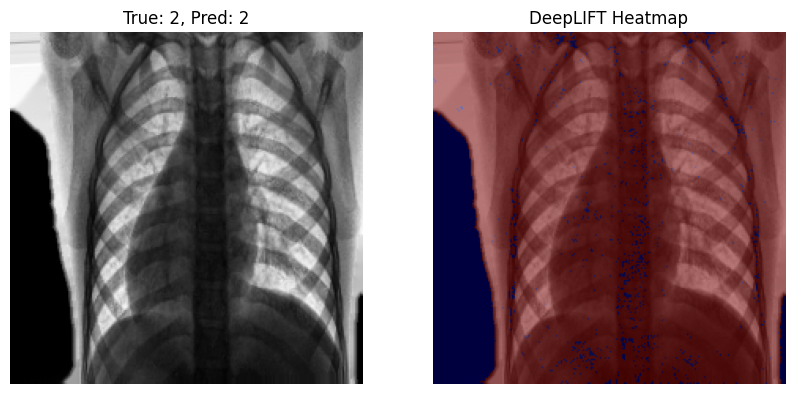

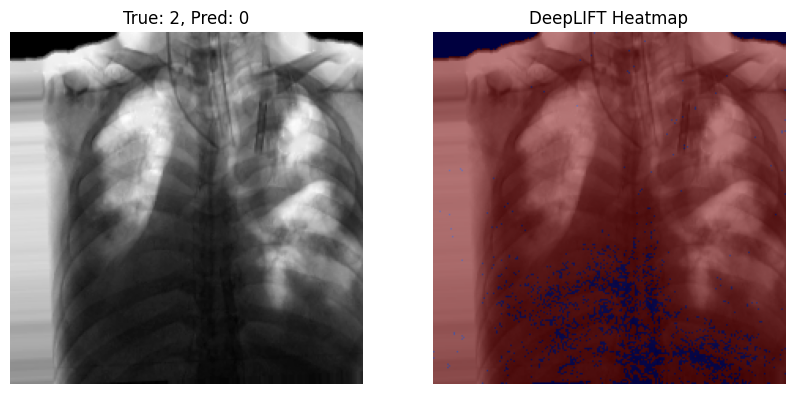

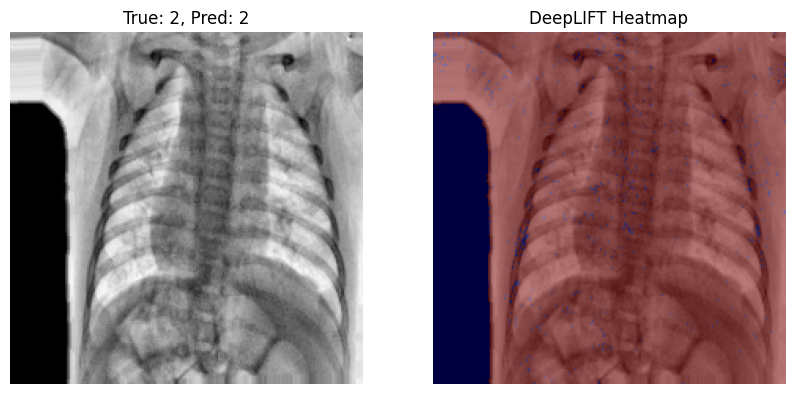

In [31]:
sample_images = np.array(selected_images)
sample_labels = np.array(selected_labels)

for i in range(len(sample_images)):
    img = sample_images[i:i+1]
    true_label = np.argmax(sample_labels[i])
    
    heatmap, pred_class = deeplift(model_c, img)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img[0])
    plt.title(f"True: {true_label}, Pred: {pred_class}")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    superimposed_img = display_heatmap(img, heatmap)
    plt.imshow(superimposed_img)
    plt.title("DeepLIFT Heatmap")
    plt.axis('off')
    
    plt.show()

# Permutation Importance

In [32]:
class_names = ['COVID-19', 'Pneumonia', 'Normal']

class_indices = {}
for i in range(len(test_labels)):
    true_label = np.argmax(test_labels[i])
    if true_label not in class_indices:
        class_indices[true_label] = i
    if len(class_indices) == 3:
        break

# Permutation Importance for model 

In [33]:
def permutation_importance(image, model, class_index, model_name, raw_image, num_permutation=50):
    image = np.expand_dims(image, axis=0)
    correct_prob = model.predict(image, verbose=0)[0, class_index]

    step_size = 24
    importance_map = np.zeros((224, 224))
    count_map = np.zeros((224, 224))

    for _ in range(num_permutation):
        i = np.random.randint(0, 224)
        j = np.random.randint(0, 224)

        i_end = min(i + step_size, 224)
        j_end = min(j + step_size, 224)

        perturbed = image.copy()
        perturbed[0, i:i_end, j:j_end, :] = np.random.rand(i_end - i, j_end - j, 3)

        pred_prob = model.predict(perturbed, verbose=0)[0, class_index]
        importance = correct_prob - pred_prob
        importance_map[i:i_end, j:j_end] += importance
        count_map[i:i_end, j:j_end] += 1

    importance_map = np.divide(importance_map, count_map, out=np.zeros_like(importance_map), where=count_map != 0)

    if np.max(importance_map) - np.min(importance_map) > 0:
        importance_map = (importance_map - np.min(importance_map)) / (np.max(importance_map) - np.min(importance_map) + 1e-8)
    else:
        importance_map = np.zeros_like(importance_map)

    plt.figure(figsize=(6, 6))
    plt.imshow(raw_image)
    plt.imshow(importance_map, cmap='hot', alpha=0.5)
    plt.title(f"{model_name}")
    plt.axis('off')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

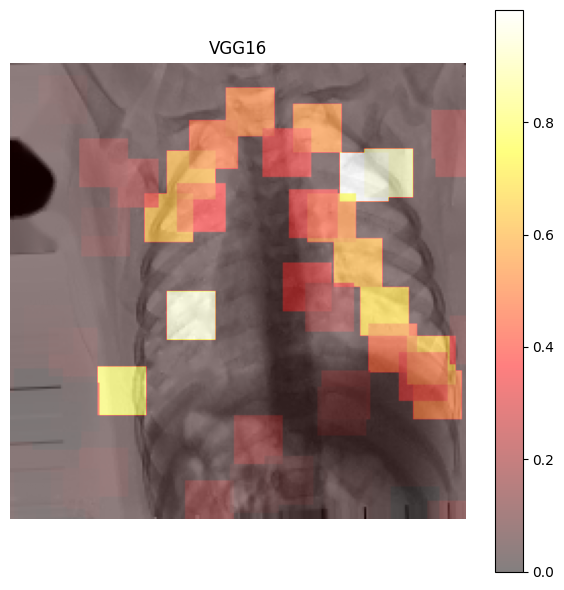

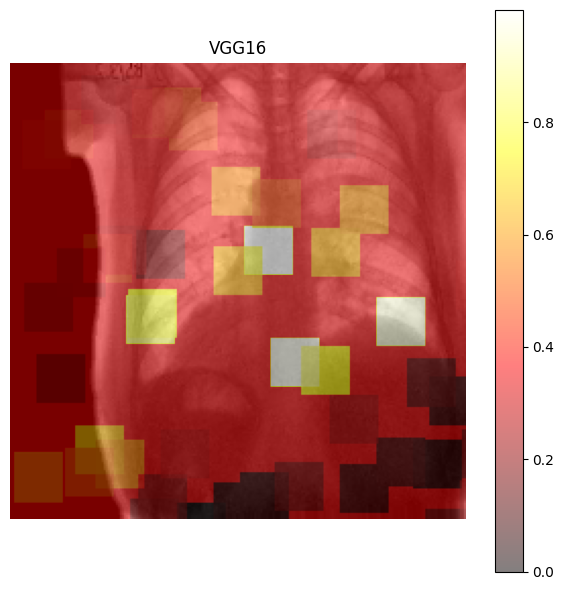

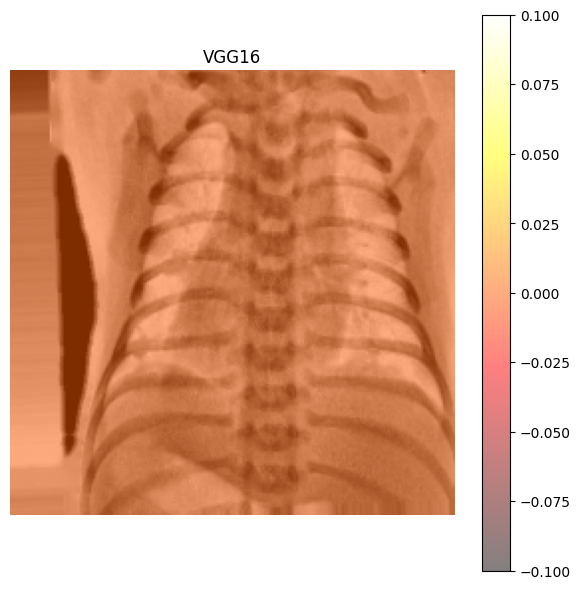

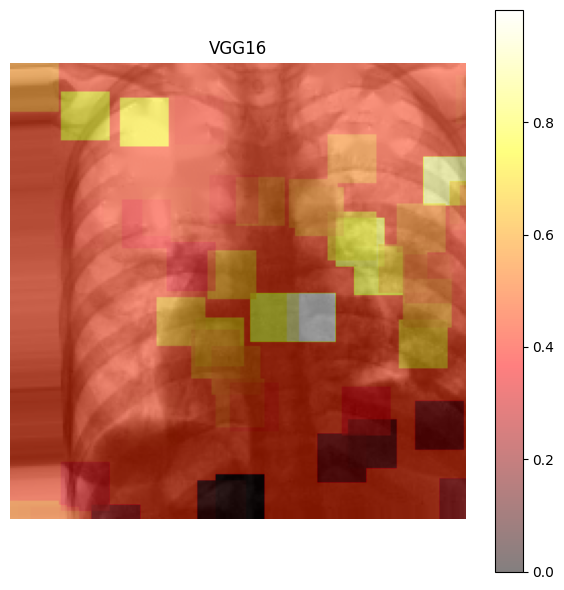

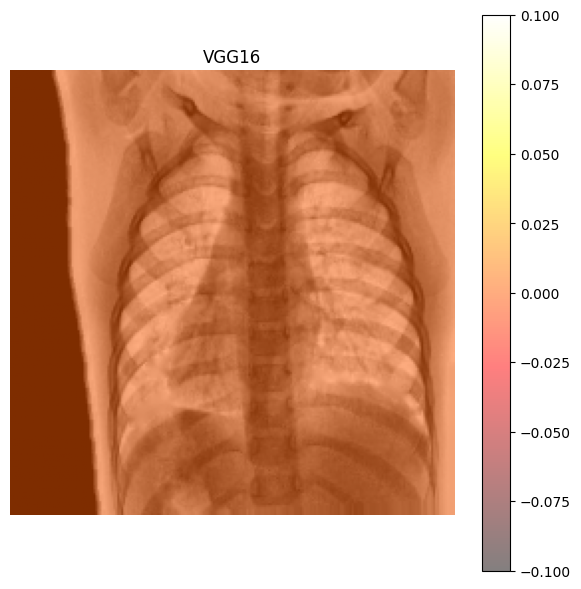

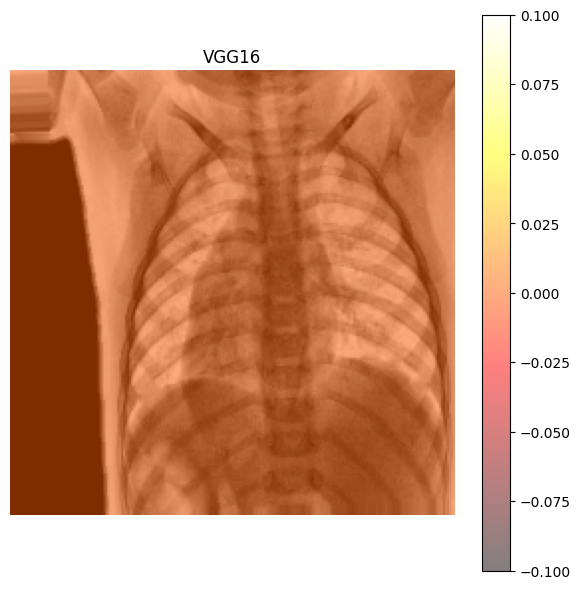

In [34]:
import random
random_indices = random.sample(range(len(test_images)), 6)

for idx in random_indices:
    image = test_images[idx]
    label_one_hot = test_labels[idx]
    true_class_index = np.argmax(label_one_hot)

    permutation_importance(image=image, model=model_c, class_index=true_class_index, model_name="VGG16", raw_image=image)

# Benchmarking

# Xception

In [35]:
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(3, activation='softmax')(x)  # 3-class output

model_x = Model(inputs=base_model.input, outputs=x)

model_x.compile(optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_x.summary()


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_129"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 111, 111, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 111, 111, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 111, 111, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 109, 109, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 109, 109, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 109, 109, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 109, 109, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 109, 109, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 109, 109, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 109, 109, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 55, 55, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 55, 55, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 23,485,995 (89.59 MB)

 Trainable params: 2,624,515 (10.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [36]:
batch_size = 32 #batch_size 32 like the paper
epochs = 10

# Train the model
history_x = model_x.fit(
    train_images, train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_images, test_labels),
    verbose=1
)


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 37s 573ms/step - accuracy: 0.5445 - loss: 1.0495 - val_accuracy: 0.7285 - val_loss: 0.5590
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - accuracy: 0.7262 - loss: 0.5743 - val_accuracy: 0.7649 - val_loss: 0.5116
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - accuracy: 0.7470 - loss: 0.5295 - val_accuracy: 0.7715 - val_loss: 0.4757
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 161ms/step - accuracy: 0.7764 - loss: 0.4709 - val_accuracy: 0.7682 - val_loss: 0.4805
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.7973 - loss: 0.4109 - val_accuracy: 0.7947 - val_loss: 0.4490
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.8116 - loss: 0.4019 - val_accuracy: 0.8013 - val_loss: 0.4458
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 0.8500 - loss: 0.3649 - val_accuracy: 0.8046 - val_loss: 0.4563
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 158ms/step - accuracy: 0.8530 - loss: 0.3597 - val_accuracy: 0

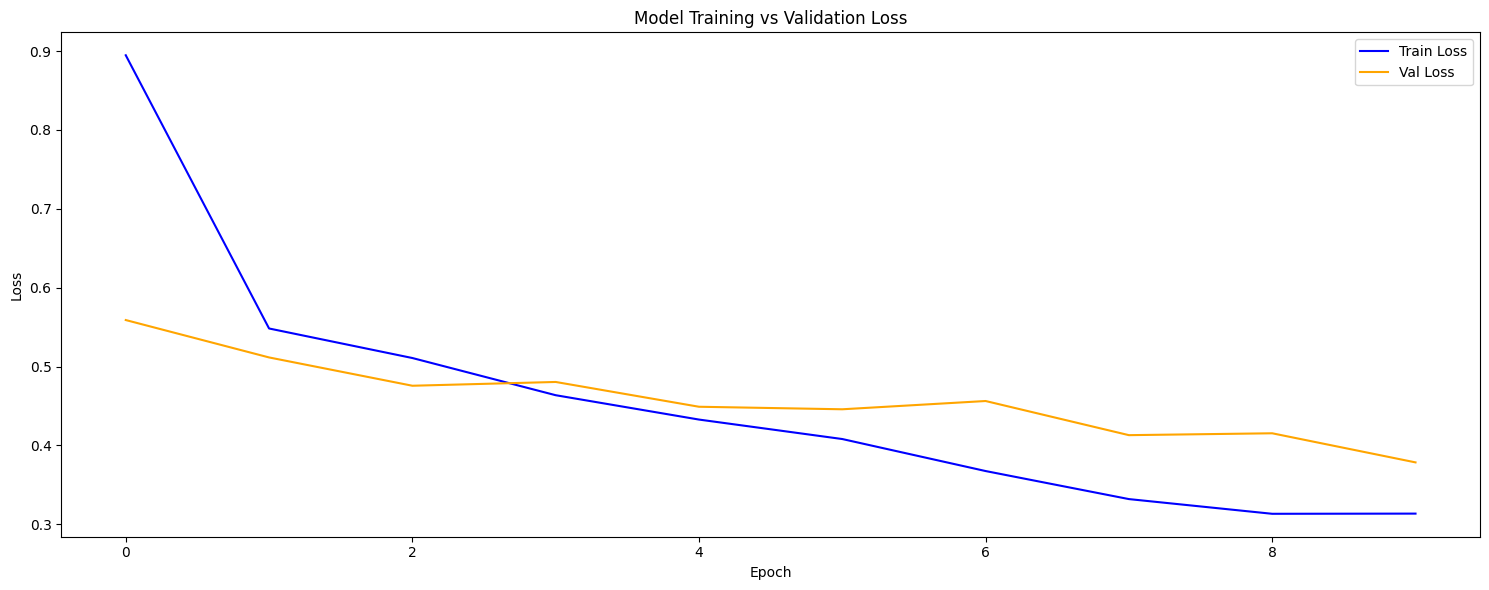

In [37]:
plt.figure(figsize=(15, 6))

plt.plot(history_x.history['loss'], label='Train Loss', color='blue')
plt.plot(history_x.history['val_loss'], label='Val Loss', color='orange')
plt.title('Model Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


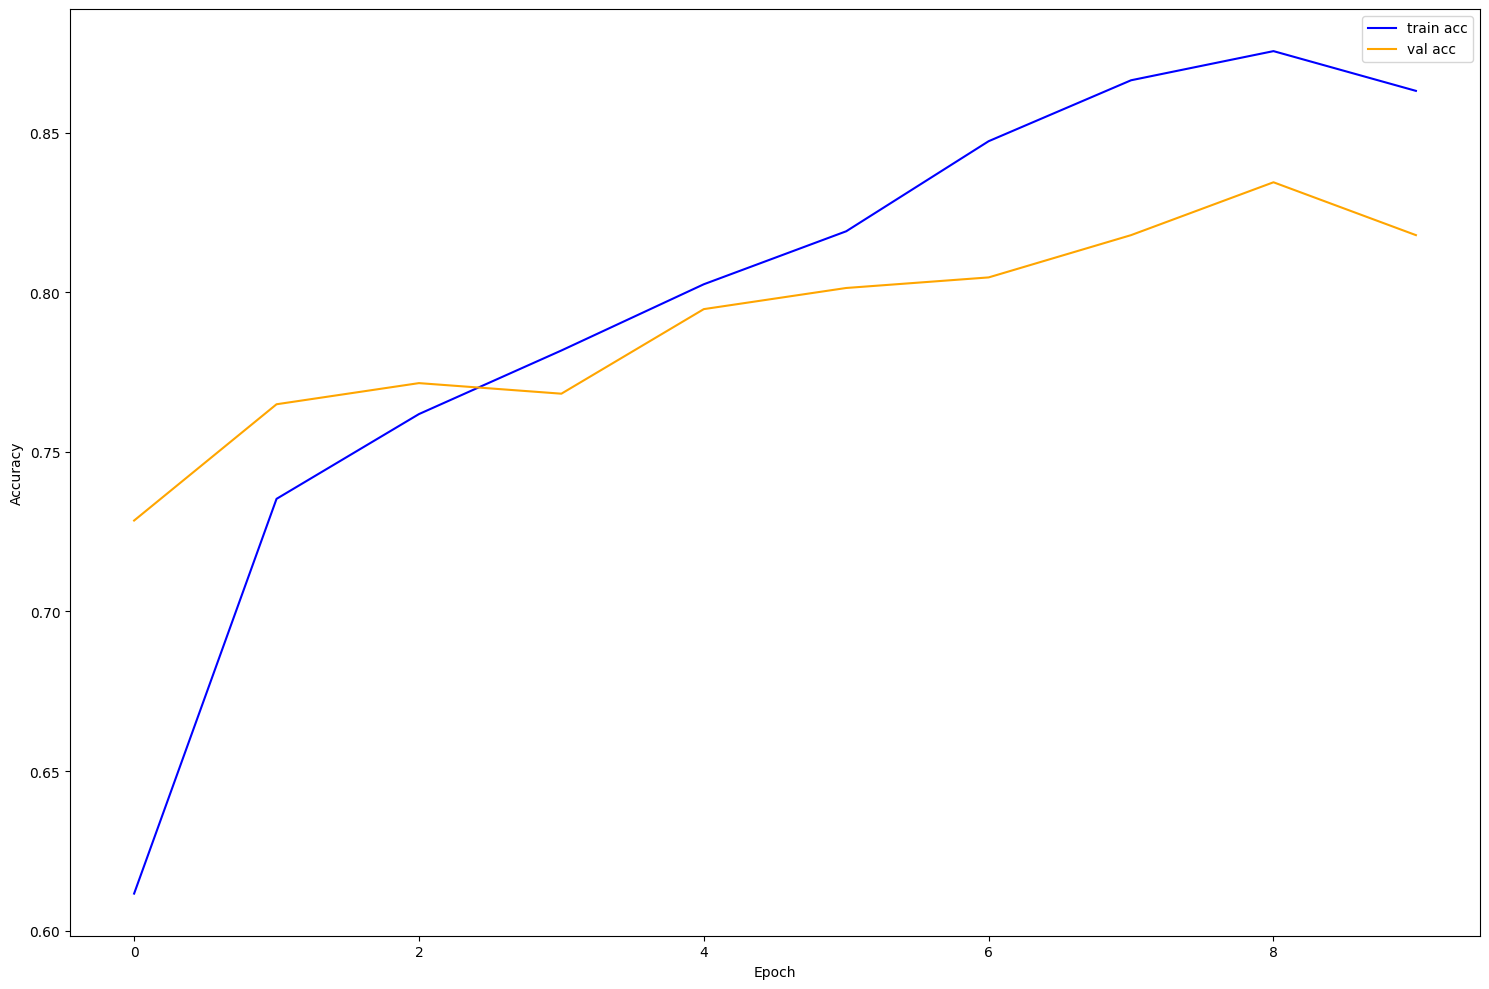

In [38]:
plt.figure(figsize=(15, 10))

plt.plot(history_x.history['accuracy'], label='train acc', color='blue')
plt.plot(history_x.history['val_accuracy'], label='val acc', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 424ms/step


Text(0.5, 1.0, 'Confusion Matrix')

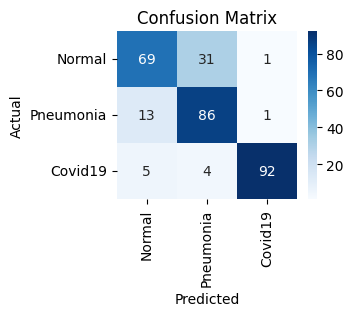

In [39]:
y_pred = model_x.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

class_names = ['Normal', 'Pneumonia', 'Covid19']
true_classes = np.argmax(test_labels, axis=1)

cm = confusion_matrix(true_classes, y_pred_classes)

plt.subplot(2, 2, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

In [40]:
auc = roc_auc_score(test_labels, y_pred, multi_class='ovr')  
print("AUC Score is: ", auc)

AUC Score is:  0.9535405480846592


# ResNet50

In [41]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = Flatten()(base_model.output)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(3, activation='softmax')(x)

model_R = Model(inputs=base_model.input, outputs=x)

model_R.compile(optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_R.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_130"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 451,427,203 (1.68 GB)

 Trainable params: 427,839,491 (1.59 GB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [42]:
batch_size = 32 #batch_size 32 like the paper
epochs = 10

# Train the model
history_R = model_R.fit(
    train_images, train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_images, test_labels),
    verbose=1
)


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 41s 568ms/step - accuracy: 0.4138 - loss: 29.7923 - val_accuracy: 0.5993 - val_loss: 0.8292
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 170ms/step - accuracy: 0.5687 - loss: 0.8246 - val_accuracy: 0.5563 - val_loss: 0.8045
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - accuracy: 0.5500 - loss: 0.8674 - val_accuracy: 0.5894 - val_loss: 0.7762
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 172ms/step - accuracy: 0.5306 - loss: 0.8586 - val_accuracy: 0.6093 - val_loss: 0.7557
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 170ms/step - accuracy: 0.5124 - loss: 0.8834 - val_accuracy: 0.6126 - val_loss: 0.7229
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 169ms/step - accuracy: 0.4401 - loss: 0.9647 - val_accuracy: 0.5894 - val_loss: 0.8332
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - accuracy: 0.4835 - loss: 0.9211 - val_accuracy: 0.5166 - val_loss: 0.9537
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.4555 - loss: 0.9515 - val_accuracy: 

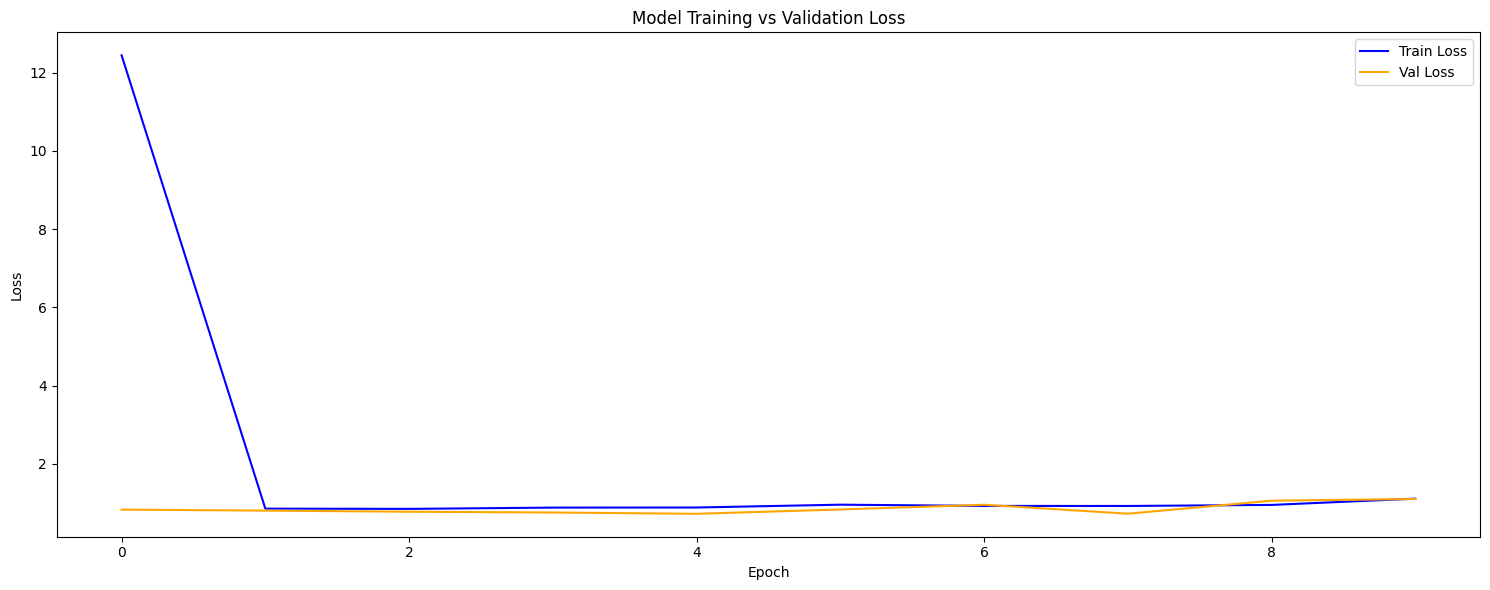

In [43]:
plt.figure(figsize=(15, 6))

plt.plot(history_R.history['loss'], label='Train Loss', color='blue')
plt.plot(history_R.history['val_loss'], label='Val Loss', color='orange')
plt.title('Model Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


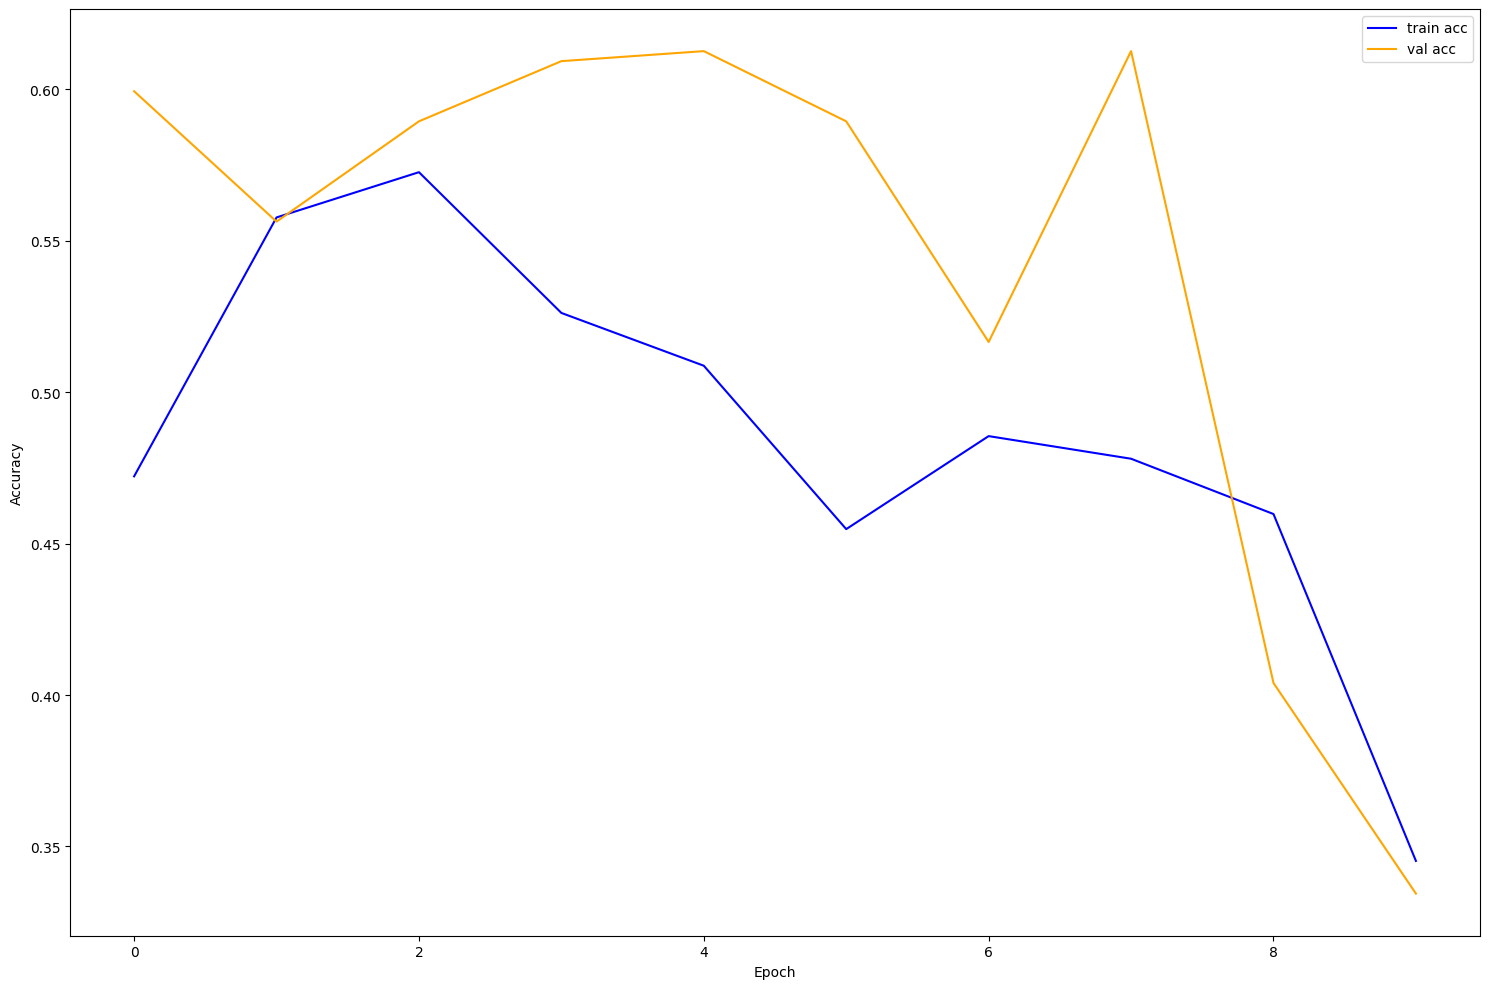

In [44]:
plt.figure(figsize=(15, 10))

plt.plot(history_R.history['accuracy'], label='train acc', color='blue')
plt.plot(history_R.history['val_accuracy'], label='val acc', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 523ms/step


Text(0.5, 1.0, 'Confusion Matrix')

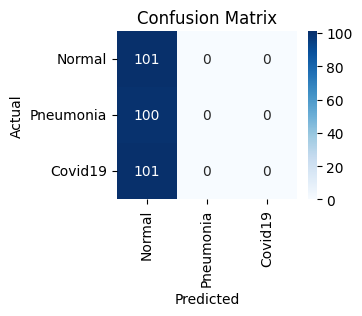

In [45]:
y_pred = model_R.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

class_names = ['Normal', 'Pneumonia', 'Covid19']
true_classes = np.argmax(test_labels, axis=1)

cm = confusion_matrix(true_classes, y_pred_classes)

plt.subplot(2, 2, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

In [46]:
auc = roc_auc_score(test_labels, y_pred, multi_class='ovr')  
print("AUC Score is: ", auc)

AUC Score is:  0.493555489877346


# XNet

In [47]:
inputs = Input(shape=(224, 224, 3))
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(3, activation='softmax')(x)

model_xNet = Model(inputs=inputs, outputs=outputs)

model_xNet.compile(optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_xNet.summary()


Model: "functional_131"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │      95,552,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,835,587 (365.58 MB)

 Trainable params: 95,835,587 (365.58 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
batch_size = 32 #batch_size 32 like the paper
epochs = 10

# Train the model
history_xNet = model_xNet.fit(
    train_images, train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_images, test_labels),
    verbose=1
)


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 16s 245ms/step - accuracy: 0.4293 - loss: 2.3828 - val_accuracy: 0.6954 - val_loss: 0.6352
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.7153 - loss: 0.5951 - val_accuracy: 0.7384 - val_loss: 0.5260
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.8319 - loss: 0.4149 - val_accuracy: 0.8311 - val_loss: 0.4451
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.8983 - loss: 0.2693 - val_accuracy: 0.8510 - val_loss: 0.4497
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9286 - loss: 0.2131 - val_accuracy: 0.8444 - val_loss: 0.6179
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9519 - loss: 0.1162 - val_accuracy: 0.8709 - val_loss: 0.5634
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9766 - loss: 0.0690 - val_accuracy: 0.8775 - val_loss: 0.5747
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9822 - loss: 0.0510 - val_accuracy: 0.8907 -

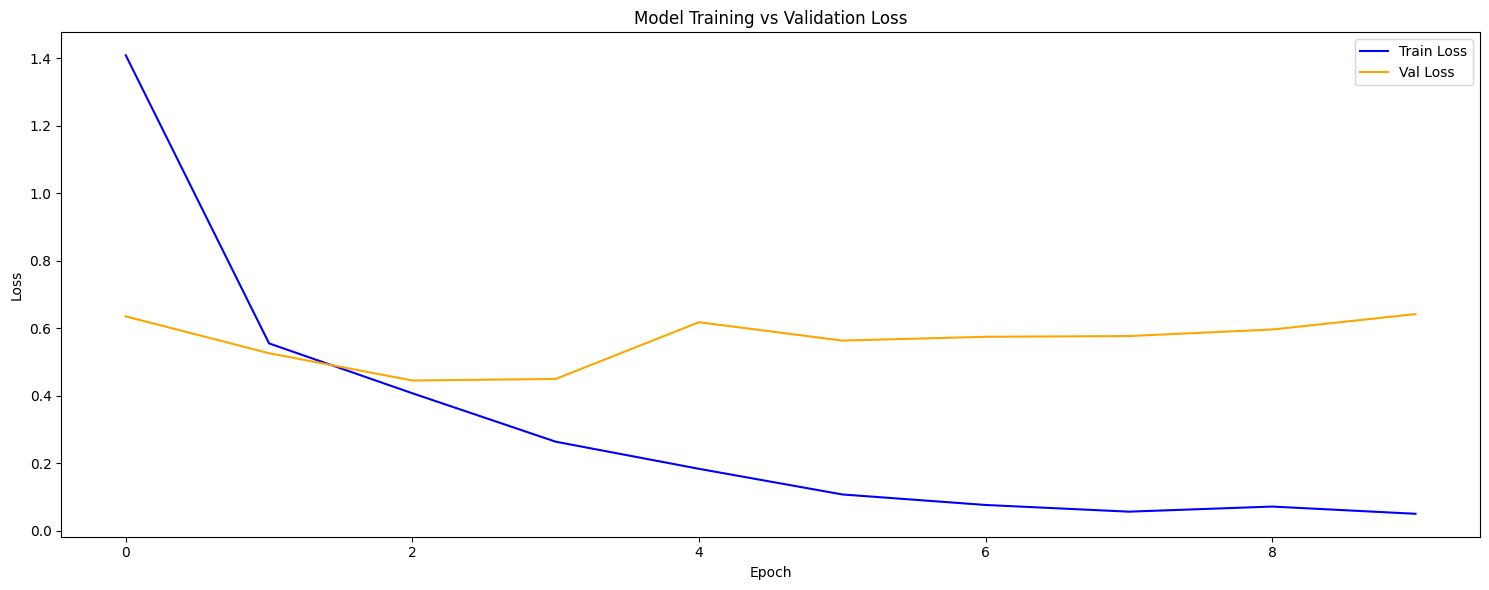

In [49]:
plt.figure(figsize=(15, 6))

plt.plot(history_xNet.history['loss'], label='Train Loss', color='blue')
plt.plot(history_xNet.history['val_loss'], label='Val Loss', color='orange')
plt.title('Model Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


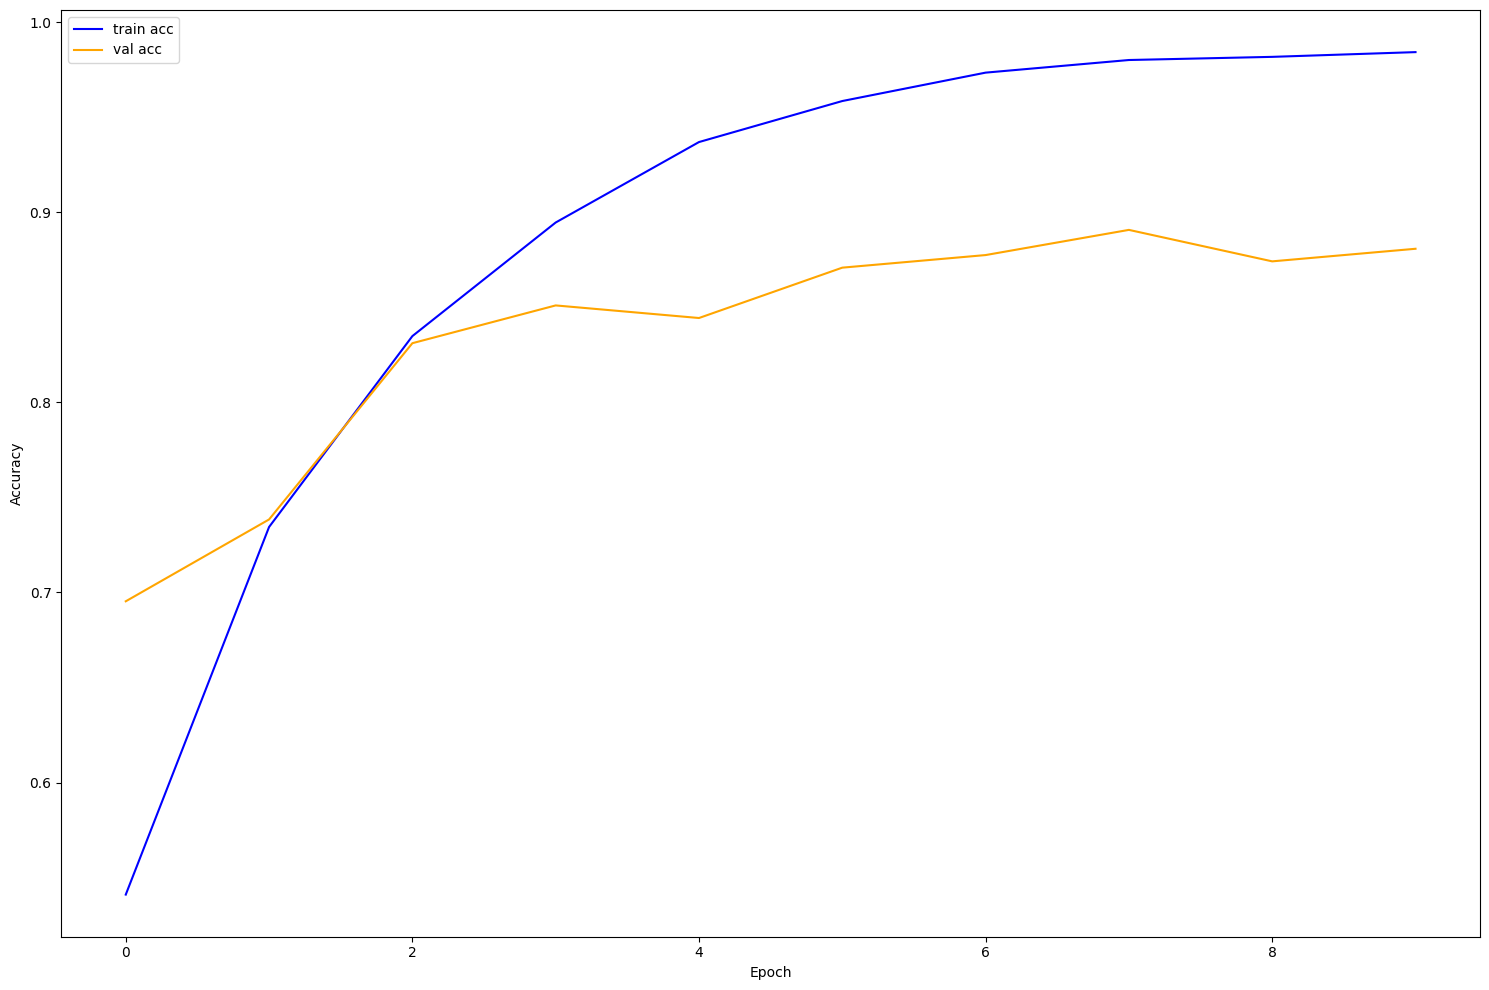

In [50]:
plt.figure(figsize=(15, 10))

plt.plot(history_xNet.history['accuracy'], label='train acc', color='blue')
plt.plot(history_xNet.history['val_accuracy'], label='val acc', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step


Text(0.5, 1.0, 'Confusion Matrix')

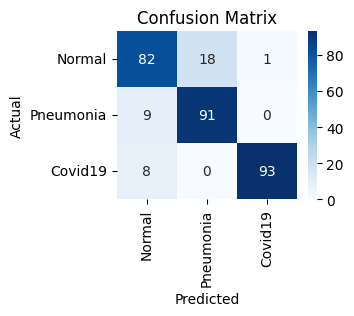

In [51]:
y_pred = model_xNet.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

class_names = ['Normal', 'Pneumonia', 'Covid19']
true_classes = np.argmax(test_labels, axis=1)

cm = confusion_matrix(true_classes, y_pred_classes)

plt.subplot(2, 2, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

In [52]:
auc = roc_auc_score(test_labels, y_pred, multi_class='ovr')  
print("AUC Score is: ", auc)

AUC Score is:  0.9590219693611153


# AlexNet

In [53]:
model_A = Sequential([
    Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((3, 3), strides=2),
    Conv2D(256, (5, 5), padding='same', activation='relu'),
    MaxPooling2D((3, 3), strides=2),
    Conv2D(384, (3, 3), padding='same', activation='relu'),
    Conv2D(384, (3, 3), padding='same', activation='relu'),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((3, 3), strides=2),
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_A.compile(optimizer=Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

model_A.summary()


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 54, 54, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 26, 26, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 12, 12, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 12, 12, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 12, 12, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 4096)                │      26,218,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 3)                   │          12,291 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 46,759,299 (178.37 MB)

 Trainable params: 46,759,299 (178.37 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
batch_size = 32 #batch_size 32 like the paper
epochs = 10

# Train the model
history_A = model_A.fit(
    train_images, train_labels,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_images, test_labels),
    verbose=1
)


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 261ms/step - accuracy: 0.4170 - loss: 2.1992 - val_accuracy: 0.5464 - val_loss: 1.0436
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.5433 - loss: 0.9309 - val_accuracy: 0.5894 - val_loss: 0.8489
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6061 - loss: 0.8074 - val_accuracy: 0.5993 - val_loss: 0.7983
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.6291 - loss: 0.7818 - val_accuracy: 0.6060 - val_loss: 0.7935
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.6541 - loss: 0.7041 - val_accuracy: 0.6225 - val_loss: 0.7354
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6794 - loss: 0.6591 - val_accuracy: 0.6556 - val_loss: 0.7138
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6819 - loss: 0.6569 - val_accuracy: 0.7152 - val_loss: 0.6661
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7189 - loss: 0.5740 - val_accuracy: 0.7053 -

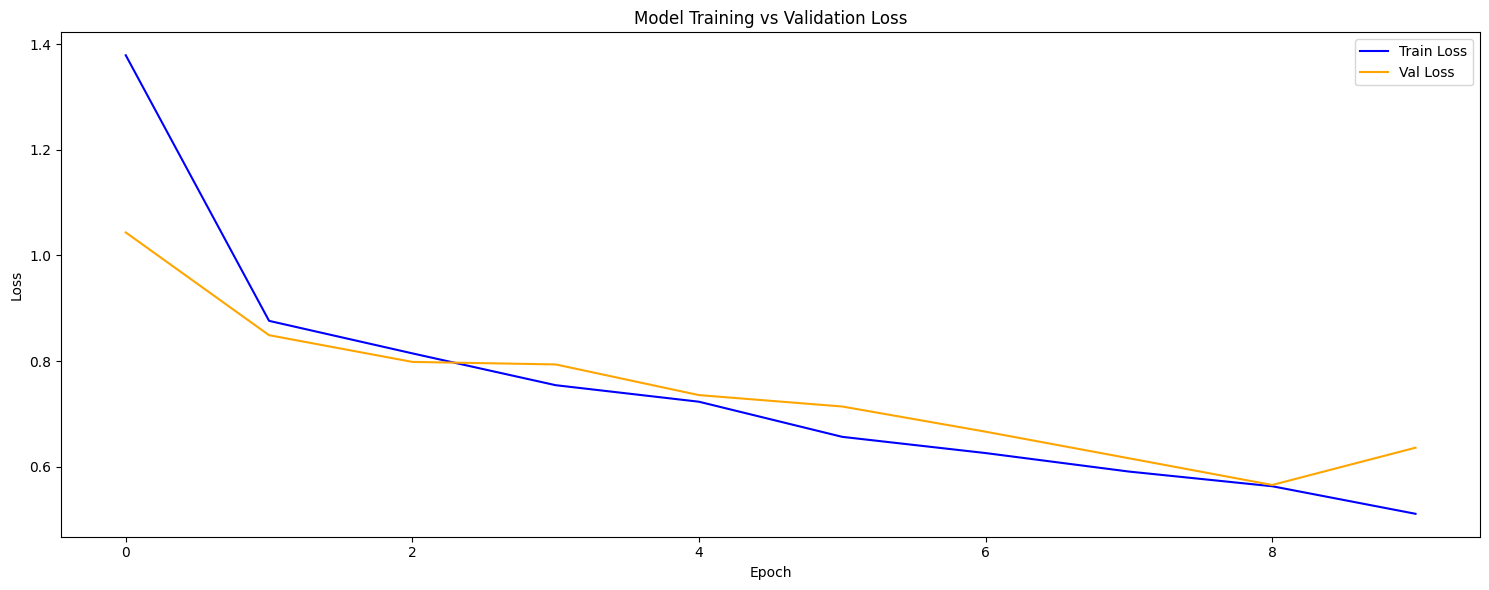

In [55]:
plt.figure(figsize=(15, 6))

plt.plot(history_A.history['loss'], label='Train Loss', color='blue')
plt.plot(history_A.history['val_loss'], label='Val Loss', color='orange')
plt.title('Model Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


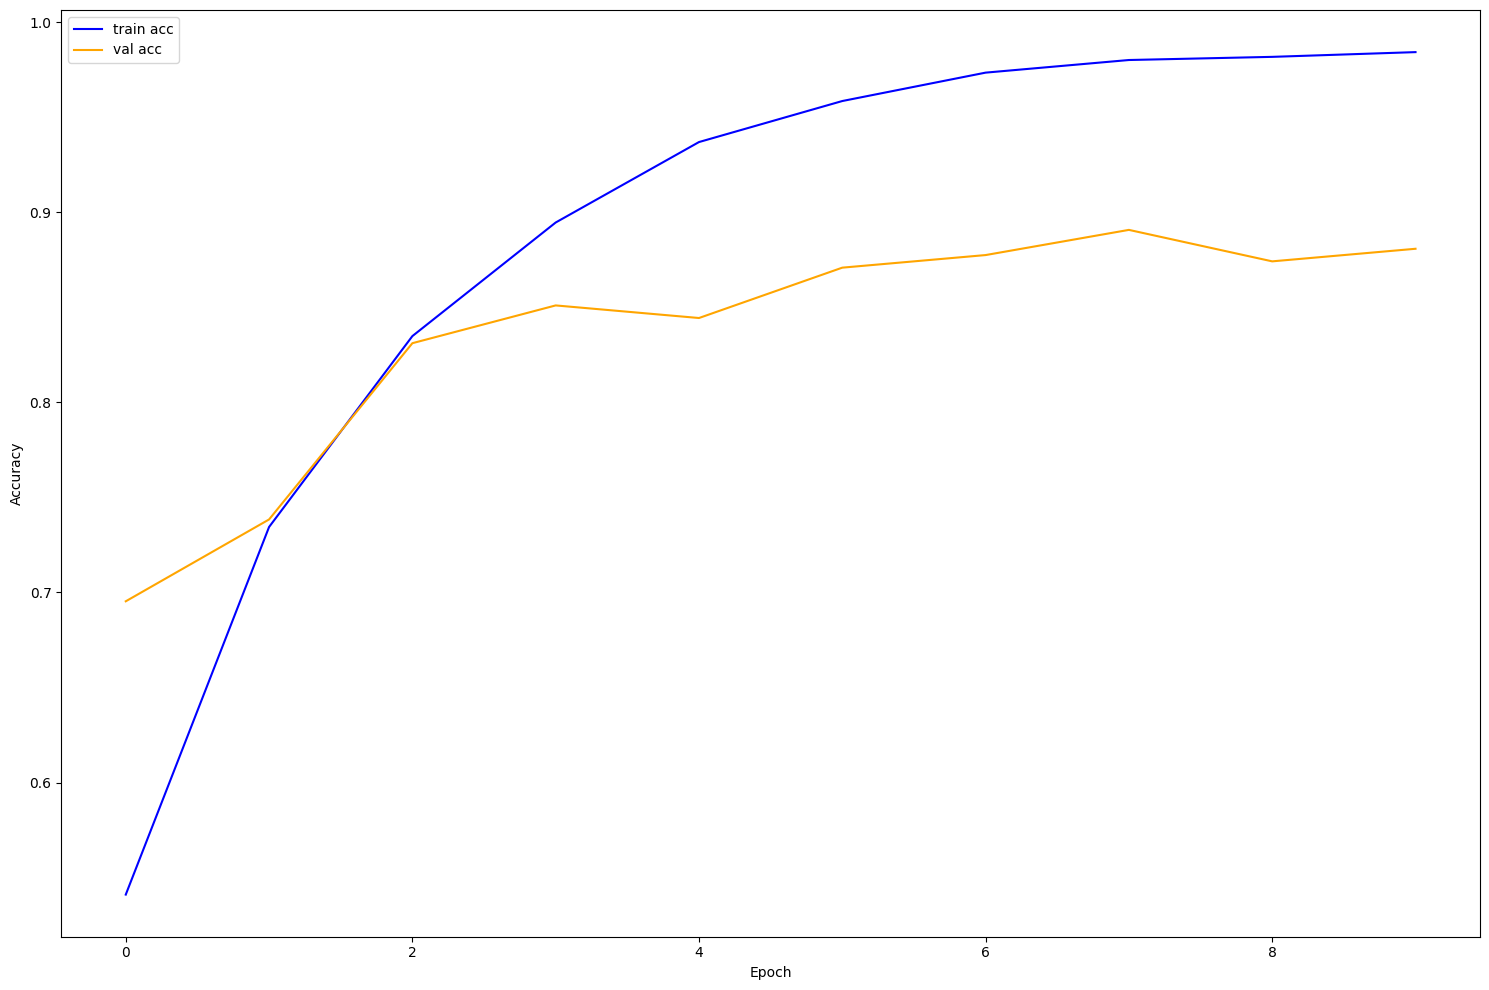

In [56]:
plt.figure(figsize=(15, 10))

plt.plot(history_xNet.history['accuracy'], label='train acc', color='blue')
plt.plot(history_xNet.history['val_accuracy'], label='val acc', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


Text(0.5, 1.0, 'Confusion Matrix')

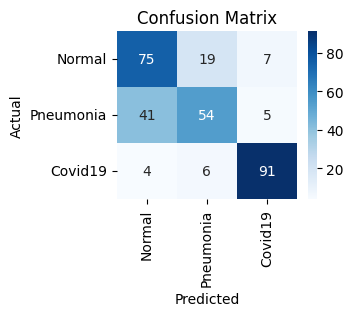

In [57]:
y_pred = model_A.predict(test_images)
y_pred_classes = np.argmax(y_pred, axis=1)

class_names = ['Normal', 'Pneumonia', 'Covid19']
true_classes = np.argmax(test_labels, axis=1)

cm = confusion_matrix(true_classes, y_pred_classes)

plt.subplot(2, 2, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

In [58]:
auc = roc_auc_score(test_labels, y_pred, multi_class='ovr')  
print("AUC Score is: ", auc)

AUC Score is:  0.8862352429272778


In [59]:
# auc = roc_auc_score(test_labels, y_pred, multi_class='ovr')  
# print("AUC Score is: ", auc)